# BE Decision Theory

## Cleaning the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp

# display all columns of df
pd.set_option('display.max_columns', None)


In [2]:
def clean_data(row_data_hdi, row_data_hci, scale=True, dowload=False):
    """
    
    """

    hdi_data = row_data_hdi.copy()
    hci_data = row_data_hci.copy()

    # drop countries if not in both datasets
    hdi_data = hdi_data[hdi_data['Country'].isin(hci_data['Country'])]
    hci_data = hci_data[hci_data['Country'].isin(hdi_data['Country'])]

    # Compute Schooling for HDI and rename columns
    hdi_data['Schooling'] = hdi_data[['Expected years of schooling', 'Mean years of schooling']].mean(axis=1)
    hdi_data['Life expectancy'] = hdi_data['Life expectancy at birth']
    hdi_data['Income'] = hdi_data['Gross national income (GNI) per capita']

    # merge dataframes on Countries
    data = pd.merge(hdi_data, hci_data, on='Country')

    # scale data min max
    if scale:
        data['Schooling'] = data['Schooling'] / data['Schooling'].max()
        data['Life expectancy'] = data['Life expectancy'] / data['Life expectancy'].max()
        data['Income'] = data['Income'] / data['Income'].max()

    # drop columns
    data = data[['Country', 'Schooling', 'Life expectancy', 'Income', 'HCI', 'HDI rank', 'HDI']]

    # compute HCI rank
    data['HCI rank'] = data['HCI'].rank(ascending=False).astype(int)

    if dowload:
        data.to_excel('data/processed/processed_data.xlsx', index=False)

    return data

In [23]:
row_data_hdi = pd.read_excel('data/processed/HDI_table.xlsx')
row_data_hci = pd.read_excel('data/processed/HCI_table.xlsx')

data = clean_data(row_data_hdi, row_data_hci, scale=True, dowload=True)
data

,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank
0,Afghanistan,0.392195,0.725166,0.020064,0.400284,180,0.478,142
1,Albania,0.761793,0.894578,0.155426,0.634251,67,0.796,48
2,Algeria,0.671854,0.893573,0.118790,0.534556,91,0.745,94
3,Angola,0.520686,0.721200,0.060115,0.362405,148,0.586,158
4,Antigua and Barbuda,0.695008,0.918377,0.184697,0.595704,71,0.788,71
...,...,...,...,...,...,...,...,...
161,Uzbekistan,0.721484,0.829049,0.087075,0.622806,101,0.727,55
162,Vanuatu,0.550603,0.824221,0.033936,0.454659,140,0.607,122
163,Vietnam,0.631182,0.861298,0.086532,0.689965,115,0.703,37
164,Zambia,0.536267,0.716286,0.035392,0.396928,154,0.565,144


We now have a cleaned data_set with only the 3 criteria we are interested in, the HCI, HDI and their respictive ranks.

## 1. Linear Program (LP) for Criteria Weights

First, let's have a look at trying to find the best weights for the criteria of HDI in order to fit at best the HCI rank. We will use a linear program to do this. We will use the following notation:

In [ ]:
# parameters
n = 3 # number of criteria (Schooling, Life expectancy,	Income)
delta = 0 # threshold for the difference between two weights, first we set it to 0, we will have a discussion about it later

Let's define a function to compute our weights for a given delta.

In [76]:
def compute_weights(data, n, delta):
    """"
    Compute the weights of the criteria for the HDI
    :param data: dataframe with the data
    :param n: number of criteria
    
    :return: weights, errors
    """
    N = data.shape[0] # number of countries
    M = int(N*(N-1)/2) # number of pairs of countries

    idx_schooling = 1
    idx_life_expectancy = 2
    idx_income = 3
    idx_hci = 4

    lp = pulp.LpProblem("HDI_Weight_Inference", pulp.LpMinimize)

    # variables
    weights = pulp.LpVariable.dicts("weights",  range(n), lowBound=0, upBound=1, cat='Continuous')
    errors = pulp.LpVariable.dicts("errors", range(M), lowBound=0, cat='Continuous')

    # objective function
    lp += pulp.lpSum(errors[i] for i in range(M))

    # constraints
    for i in range(N):
        for k in range(i +1 , N):
            f_ij = data.iloc[i, idx_schooling:idx_income + 1].values
            f_ik = data.iloc[k, idx_schooling:idx_income + 1].values
            if data.iloc[i, idx_hci] > data.iloc[k, idx_hci]:
                lp += pulp.lpSum(weights[j]*(f_ij[j] - f_ik[j]) for j in range(n)) + errors[i] >= delta
            else:
                lp += pulp.lpSum(weights[j]*(f_ik[j] - f_ij[j]) for j in range(n)) + errors[i] >= delta
    lp += pulp.lpSum(weights[j] for j in range(n)) == 1

    lp.solve()

    # print the results
    print(f"Compute weights for HDI with {N} countries and {n} criteria")
    print("Status:", pulp.LpStatus[lp.status])
    print(f"delta = {delta}")
    print("Optimal weights:")
    for v in lp.variables():
        if v.name.startswith('weights'):
            print(v.name, "=", v.varValue)

    weights = [v.varValue for v in lp.variables() if v.name.startswith('weights')]
    errors = [v.varValue for v in lp.variables() if v.name.startswith('errors')]
    print("Sum of errors:", sum(errors))

    return weights, errors


Let's run the function on delta = 0

In [5]:
weights, errors = compute_weights(data, n, delta)

Compute weights for HDI with 165 countries and 3 criteria
Status: Optimal
delta = 0
Optimal weights:
weights_0 = 0.25581413
weights_1 = 0.74418587
weights_2 = 0.0
Sum of errors: 9.214173333700003


We found the weights for each criteria (weight_0=schooling, weight_1=life_expectency, weight_2=income) that minimized the errors on each pairs of country rank comparision.
We might fix our goal on optimizing the mean rank difference between the new computed with the weights found and the hci rank.
To do so, we are searching for the best delta that minimze this rank difference:

In [12]:
deltas = np.linspace(0, 1, 100)
weight_error_delta = [compute_weights(data, n, delta) for delta in deltas]
weights_delta = [weight_error[0] for weight_error in weight_error_delta]
errors_delta = [weight_error[1] for weight_error in weight_error_delta]

Compute weights for HDI with 164 countries and 3 criteria
Status: Optimal
delta = 0.0
Optimal weights:
weights_0 = 0.26530797
weights_1 = 0.73469203
weights_2 = 0.0
Sum of errors: 8.912015513560004
Compute weights for HDI with 164 countries and 3 criteria
Status: Optimal
delta = 0.010101010101010102
Optimal weights:
weights_0 = 0.27602816
weights_1 = 0.72397184
weights_2 = 0.0
Sum of errors: 10.445763722799995
Compute weights for HDI with 164 countries and 3 criteria
Status: Optimal
delta = 0.020202020202020204
Optimal weights:
weights_0 = 0.27688652
weights_1 = 0.72311348
weights_2 = 0.0
Sum of errors: 12.017519904199998
Compute weights for HDI with 164 countries and 3 criteria
Status: Optimal
delta = 0.030303030303030304
Optimal weights:
weights_0 = 0.27688652
weights_1 = 0.72311348
weights_2 = 0.0
Sum of errors: 13.603518621859997
Compute weights for HDI with 164 countries and 3 criteria
Status: Optimal
delta = 0.04040404040404041
Optimal weights:
weights_0 = 0.27688652
weights_1 = 

In [6]:
def compute_new_rank(data_src, weights):
    data = data_src.copy()
    data['New HDI'] = data['Schooling']*weights[0] + data['Life expectancy']*weights[1] + data['Income']*weights[2]
    data['New HDI rank'] = data['New HDI'].rank(ascending=False).astype(int)
    data['diff rank'] = (data['New HDI rank'] - data['HDI rank']).abs()
    diff_rank_mean = data['diff rank'].mean()
    return data, diff_rank_mean
    

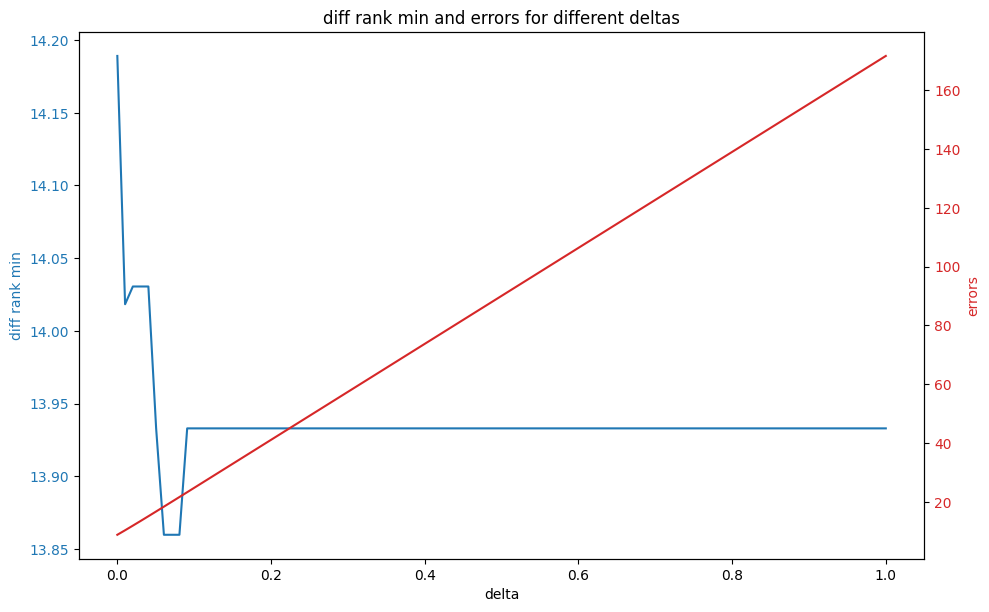

delta min for best weights: 0.06060606060606061


In [15]:
diff_rank_min_deltas = []
sum_errors_deltas = [sum(errors) for errors in errors_delta]
for weights in weights_delta:
    data_new, diff_rank_min = compute_new_rank(data, weights)
    diff_rank_min_deltas.append(diff_rank_min)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('delta')
ax1.set_ylabel('diff rank min', color=color)
ax1.plot(deltas, diff_rank_min_deltas, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('errors', color=color)  # we already handled the x-label with ax1
ax2.plot(deltas, sum_errors_deltas, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('diff rank min and errors for different deltas')
plt.show()

print(f"delta min for best weights: {deltas[np.argmin(diff_rank_min_deltas)]}")

Using this rank difference as a metric we find that the best delta is 0.06. Let's compute the new weights with this delta.

In [24]:
weights, errors = compute_weights(data, n, delta=0.06)

Compute weights for HDI with 166 countries and 3 criteria
Status: Optimal
delta = 0.06
Optimal weights:
weights_0 = 0.25974118
weights_1 = 0.74025882
weights_2 = 0.0
Sum of errors: 18.856555571000005


We find a weight for income equal to 0. It's not really suprizing since the HCI is calculated with health and education wich are highly related to the two first criteria of HDI. \
Let's now find out if over the different relations in the assignement, some are not respected in regard to our weights found.

In [30]:
data_final, diff_rank_min = compute_new_rank(data, weights)
data_final
countries = [("Vietnam","Kazakhstan"),
             ("Slovenia","Spain"),
             ("Turkey","Argentina"),
             ("Nepal","Ghana"),
             ("Zimbabwe","Iraq"),
             ("Japan","Switzerland"),
             ("Kenya","Honduras"),
             ("Peru","Kuwait"),
             ]

miss_matching_countries = []
for country_1, country_2 in countries:
    country_1_new_rank = data_final[data_final["Country"] == country_1]["New HDI rank"].values[0]
    country_2_new_rank = data_final[data_final["Country"] == country_2]["New HDI rank"].values[0]
    print(f"country_1 = {country_1}, new rank = {country_1_new_rank}, country_2 = {country_2}, new rank = {country_2_new_rank}")
    if country_1_new_rank <= country_2_new_rank:
        miss_matching_countries.append((country_1, country_2))
print(f"miss_matching_countries = {miss_matching_countries}")

country_1 = Vietnam, new rank = 87, country_2 = Kazakhstan, new rank = 74
country_1 = Slovenia, new rank = 23, country_2 = Spain, new rank = 18
country_1 = Turkey, new rank = 43, country_2 = Argentina, new rank = 39
country_1 = Nepal, new rank = 117, country_2 = Ghana, new rank = 125
country_1 = Zimbabwe, new rank = 136, country_2 = Iraq, new rank = 108
country_1 = Japan, new rank = 10, country_2 = Switzerland, new rank = 6
country_1 = Kenya, new rank = 143, country_2 = Honduras, new rank = 113
country_1 = Peru, new rank = 70, country_2 = Kuwait, new rank = 50
miss_matching_countries = [('Nepal', 'Ghana')]


We only find one paire ('Nepal', 'Ghana'), that doesn't fit the equation rule. 

Let's now have a look at Croatia and its ranks.

In [32]:
country = "Croatia"
data_final[data_final["Country"] == country]


,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank,New HDI,New HDI rank,diff rank
36,Croatia,0.808231,0.907655,0.33142,0.709694,40,0.858,30,0.881831,37,3


We find that Croatia has a new rank of 37, a HCI rank of 30. Then there is a 7 places difference over these two ranks.

Bonus : Let's have a look on how many pairs have been miss ranked.

In [48]:
N = data_final.shape[0]
not_matching_country = []
for i in range(N):
    for j in range(i + 1, N):
        country_i = data_final.iloc[i][0]
        country_j = data_final.iloc[j][0]
        country_i_new_rank = data_final[data_final["Country"] == country_i]["New HDI rank"].values[0]
        country_j_new_rank = data_final[data_final["Country"] == country_j]["New HDI rank"].values[0]
                
        country_i_hdi_rank = data_final[data_final["Country"] == country_i]["HDI rank"].values[0]
        country_j_hdi_rank = data_final[data_final["Country"] == country_j]["HDI rank"].values[0]

        is_hdi_i_inf_j = country_i_hdi_rank < country_j_hdi_rank
        is_new_rank_i_inf_j = country_i_new_rank < country_j_new_rank

        if not is_hdi_i_inf_j == is_new_rank_i_inf_j:
            if is_hdi_i_inf_j:
                not_matching_country.append((country_j, country_i))
            else: 
                not_matching_country.append((country_i, country_j))


C:\Users\julie\AppData\Local\Temp\ipykernel_26760\883536816.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  country_i = data_final.iloc[i][0]
C:\Users\julie\AppData\Local\Temp\ipykernel_26760\883536816.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  country_j = data_final.iloc[j][0]


In [49]:
print(len(not_matching_country))
print(N*(N+1)/2)


913
13861.0


Over the 13861 pairs comparision 913 have been miss ranked with our weight.

## 2. Data Envelopment Analysis (DEA) for Efficient Countries

Let's start with a new fresh data set:

In [78]:
data_dea = clean_data(row_data_hdi, row_data_hci, scale=True, dowload=True)
data_dea

,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank
0,Afghanistan,0.392195,0.725166,0.020064,0.400284,180,0.478,142
1,Albania,0.761793,0.894578,0.155426,0.634251,67,0.796,48
2,Algeria,0.671854,0.893573,0.118790,0.534556,91,0.745,94
3,Angola,0.520686,0.721200,0.060115,0.362405,148,0.586,158
4,Antigua and Barbuda,0.695008,0.918377,0.184697,0.595704,71,0.788,71
...,...,...,...,...,...,...,...,...
161,Uzbekistan,0.721484,0.829049,0.087075,0.622806,101,0.727,55
162,Vanuatu,0.550603,0.824221,0.033936,0.454659,140,0.607,122
163,Vietnam,0.631182,0.861298,0.086532,0.689965,115,0.703,37
164,Zambia,0.536267,0.716286,0.035392,0.396928,154,0.565,144


Let's now define our new lp problem for finding the efficency of one country using DEA:

In [79]:
# Compute efficency for each country use DEA (Analyse Enveloppante des Données en français)

def compute_efficiency(data_dea, country, verbose=False):
    n = 3 # number of criteria (Schooling, Life expectancy,	Income) : INPUTS
    m = 1 # number of criteria (HCI) : OUTPUTS
    
    col_input_idx = 1
    col_output_idx = 4

    N = data_dea.shape[0] # number of countries

    lp = pulp.LpProblem("HDI_Efficiency", pulp.LpMinimize)

    # variables
    efficency_country = pulp.LpVariable(country, lowBound=0, cat='Continuous')
    weights = pulp.LpVariable.dicts("weights",  range(N), lowBound=0, cat='Continuous')

    # objective function
    lp += efficency_country

    # constraints
    for i in range(n):
       lp += pulp.lpSum(weights[j]*(1-data_dea.iloc[j, col_input_idx + i]) for j in range(N)) == (1-data_dea.iloc[data_dea[data_dea['Country'] == country].index[0], col_input_idx + i])*efficency_country

    lp += pulp.lpSum(weights[j] for j in range(N)) == 1

    lp.solve()

    # print the results
    weights = [v.varValue for v in lp.variables() if v.name.startswith('weights')]
    if verbose:
        print(f"Compute efficency for {country} with {N} countries and {n} criteria")
        print("Status:", pulp.LpStatus[lp.status])
    
        print("Optimal weights:")
        for v in lp.variables():
            if v.name.startswith('weights'):
                print(v.name, "=", v.varValue)
        print("Sum of weights:", sum(weights))


    efficency = efficency_country.varValue

    return efficency, weights


Let's compute the efficency of some countries to see if their HCI is well maximized by their HDI criteria. (Or in our case to see if 1-HCI  is well minimized by the 1-criteria as we took the problem the reverse way.)

In [80]:
country = 'France'
efficency_country, weights = compute_efficiency(data_dea, country)
print(f"efficency for {country}: {efficency_country}")

efficency for France: 0.48734065


In [55]:
country = "Estonia"
efficency_country, weights = compute_efficiency(data_dea, country)
print(f"efficency for {country}: {efficency_country}")

efficency for Estonia: 0.51789541


France and Estonia don't score very well. 1 beeing the best 0 the worst.

Let's compute the efficency for each country:

In [82]:
efficencies = []
for country in data_dea['Country']:
    efficency_country, weights = compute_efficiency(data_dea, country)
    efficencies.append(efficency_country)

data_dea['Efficency'] = efficencies
data_dea['Efficency rank'] = data_dea['Efficency'].rank(ascending=False).astype(int)

data_dea

,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank,Efficency,Efficency rank
0,Afghanistan,0.392195,0.725166,0.020064,0.400284,180,0.478,142,0.168443,159
1,Albania,0.761793,0.894578,0.155426,0.634251,67,0.796,48,0.291713,77
2,Algeria,0.671854,0.893573,0.118790,0.534556,91,0.745,94,0.247496,102
3,Angola,0.520686,0.721200,0.060115,0.362405,148,0.586,158,0.215817,118
4,Antigua and Barbuda,0.695008,0.918377,0.184697,0.595704,71,0.788,71,0.269424,92
...,...,...,...,...,...,...,...,...,...,...
161,Uzbekistan,0.721484,0.829049,0.087075,0.622806,101,0.727,55,0.276073,89
162,Vanuatu,0.550603,0.824221,0.033936,0.454659,140,0.607,122,0.196755,135
163,Vietnam,0.631182,0.861298,0.086532,0.689965,115,0.703,37,0.226412,115
164,Zambia,0.536267,0.716286,0.035392,0.396928,154,0.565,144,0.220766,116


We can sort them by efficency:

In [83]:
data_dea.sort_values(by=['Efficency', 'HCI'], ascending=[False, False]).head(15)

,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank,Efficency,Efficency rank
136,Singapore,0.842156,0.968190,1.000000,0.879126,12,0.939,1,1.000000,6
62,"Hong Kong SAR, China",0.873391,1.000000,0.688603,0.812757,4,0.952,2,1.000000,6
69,Ireland,0.903676,0.959335,0.837771,0.792599,8,0.945,8,1.000000,6
107,New Zealand,0.983635,0.964643,0.484580,0.775932,13,0.937,12,1.000000,6
7,Australia,1.000000,0.988922,0.541566,0.770240,5,0.951,15,1.000000,6
64,Iceland,0.974803,0.967297,0.613538,0.745282,3,0.959,26,1.000000,6
159,United States,0.887009,0.903184,0.712343,0.701764,21,0.921,34,1.000000,6
115,Palau,0.837021,0.772409,0.151989,0.588113,80,0.767,74,1.000000,6
139,South Africa,0.740551,0.729361,0.142417,0.425453,109,0.713,130,1.000000,6
84,Lesotho,0.534349,0.620801,0.029702,0.400393,168,0.514,140,1.000000,6


Let's see which countries lie at the efficency frontier (most efficent , efficency=1)

In [84]:
efficency_frontier = data_dea[data_dea['Efficency'] == 1]
efficency_frontier

,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank,Efficency,Efficency rank
7,Australia,1.000000,0.988922,0.541566,0.770240,5,0.951,15,1.0,6
62,"Hong Kong SAR, China",0.873391,1.000000,0.688603,0.812757,4,0.952,2,1.0,6
64,Iceland,0.974803,0.967297,0.613538,0.745282,3,0.959,26,1.0,6
69,Ireland,0.903676,0.959335,0.837771,0.792599,8,0.945,8,1.0,6
84,Lesotho,0.534349,0.620801,0.029702,0.400393,168,0.514,140,1.0,6
107,New Zealand,0.983635,0.964643,0.484580,0.775932,13,0.937,12,1.0,6
110,Nigeria,0.512372,0.616285,0.052688,0.360610,163,0.535,160,1.0,6
115,Palau,0.837021,0.772409,0.151989,0.588113,80,0.767,74,1.0,6
136,Singapore,0.842156,0.968190,1.000000,0.879126,12,0.939,1,1.0,6
139,South Africa,0.740551,0.729361,0.142417,0.425453,109,0.713,130,1.0,6


11 countries lie at the efficency frontier: Australia, Hong Kong, Iceland, Ireland, Lesotho, New Zealand, Nigeria, Palau, Singapore, South Africa, and the United States.

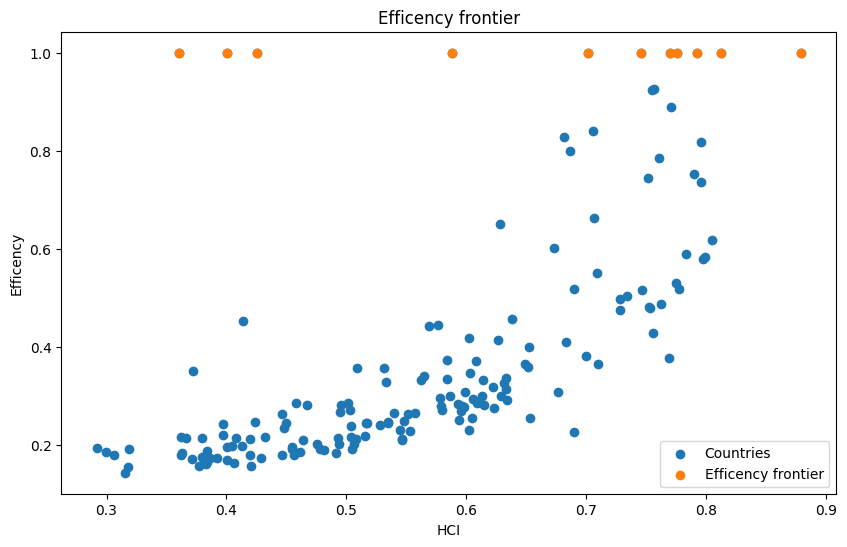

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(data_dea['HCI'], data_dea['Efficency'], label='Countries')
plt.scatter(efficency_frontier['HCI'], efficency_frontier['Efficency'], label='Efficency frontier')
plt.xlabel('HCI')
plt.ylabel('Efficency')
plt.title('Efficency frontier')
plt.legend()
plt.show()

let's have a closure look at Estonia.
Let's retrieve the weights found on each Country for Estonia.

In [69]:
country = "Estonia"
efficency_country_estonia, weights = compute_efficiency(data_dea, country)
print(f"efficency for {country}: {efficency_country_estonia}")
print(f"weights for {country}: {weights}")



efficency for Estonia: 0.51789541
weights for Estonia: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24321174, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48355169, 0.0, 0.0, 0.0, 0.0, 0.27323657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


the DEA model will provide target values for each input criterion. These target values represent the levels at which Estonia would need to adjust its input criteria (HDI components) to become efficient.
The target output (HCI) will be set at a level that an efficient country with similar inputs achieves.
We find these efficent countries for Estonia by looking at the weights != 0.

In [70]:
weights_estonia_not_null_idx = [i for i in range(len(weights)) if weights[i] != 0]
weights_estonia_not_null = [weights[i] for i in weights_estonia_not_null_idx]
print(f"weights_estonia_not_null_idx = {weights_estonia_not_null_idx}")
print(f"weights_estonia_not_null = {weights_estonia_not_null}")
data_dea.iloc[weights_estonia_not_null_idx,:]


weights_estonia_not_null_idx = [67, 127, 132]
weights_estonia_not_null = [0.24321174, 0.48355169, 0.27323657]


,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank,Efficency,Efficency rank,Indicator
67,"Iran, Islamic Rep.",0.747503,0.864303,0.142993,0.593404,76,0.774,73,0.282846,82,0.212498
127,St. Kitts and Nevis,0.713127,0.838649,0.256915,0.586182,75,0.777,75,0.300652,72,0.189706
132,Senegal,0.352315,0.784953,0.036784,0.420111,170,0.511,132,0.157949,163,0.148523


In [ ]:
schooling_criteria_estonia = sum([weights_estonia_not_null[i]*(1-data_dea.iloc[weights_estonia_not_null_idx[i], 1]) for i in (0,1,2)])

In [71]:
schooling_criteria_estonia = weights_estonia_not_null[0]*(1-data_dea.iloc[weights_estonia_not_null_idx[0], 1])
life_expectancy_criteria_estonia = weights_estonia_not_null[1]*(1-data_dea.iloc[weights_estonia_not_null_idx[1], 1])
income_criteria_estonia = weights_estonia_not_null[2]*(1-data_dea.iloc[weights_estonia_not_null_idx[2], 1])

print(f"schooling_criteria_estonia = {schooling_criteria_estonia}")
print(f"life_expectancy_criteria_estonia = {life_expectancy_criteria_estonia}")
print(f"income_criteria_estonia = {income_criteria_estonia}")


efficency_schooling_estonia = efficency_country_estonia*(1-data_dea[data_dea["Country"] == "Estonia"]["Schooling"].values[0])
efficency_life_expectancy_estonia = efficency_country_estonia*(1-data_dea[data_dea["Country"] == "Estonia"]["Life expectancy"].values[0])
efficency_income_estonia = efficency_country_estonia*(1-data_dea[data_dea["Country"] == "Estonia"]["Income"].values[0])

print(f"efficency_schooling_estonia = {efficency_schooling_estonia}")
print(f"efficency_life_expectancy_estonia = {efficency_life_expectancy_estonia}")
print(f"efficency_income_estonia = {efficency_income_estonia}")

schooling_criteria_estonia = 0.061410254252122876
life_expectancy_criteria_estonia = 0.13871791188363736
income_criteria_estonia = 0.17697130385220253
efficency_schooling_estonia = 0.06598398799159189
efficency_life_expectancy_estonia = 0.05047143539648589
efficency_income_estonia = 0.3011629542764249


In [73]:
data_dea[data_dea["Country"] == "Estonia"]

,Country,Schooling,Life expectancy,Income,HCI,HDI rank,HDI,HCI rank,Efficency,Efficency rank,Indicator
45,Estonia,0.872592,0.902545,0.418487,0.777203,31,0.89,11,0.517895,32,0.110365


In [75]:
target_schooling_estonia = 1 - schooling_criteria_estonia/efficency_country_estonia
target_life_expectency_estonia = 1 - life_expectancy_criteria_estonia/efficency_country_estonia
target_income_estonia = 1 - income_criteria_estonia/efficency_country_estonia

print(f"target_schooling_estonia = {target_schooling_estonia}")
print(f"target_life_expectency_estonia = {target_life_expectency_estonia}")
print(f"target_income_estonia = {target_income_estonia}")


target_schooling_estonia = 0.6489610020913736
target_life_expectency_estonia = 0.33416328575616716
target_income_estonia = 0.8141221870497027
